In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
import torch.distributions as td

import numpy as np
from numpy.random import normal, randint, choice

import scipy as sp
from scipy.special import softmax

import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# class MCAgent(Agent):
#     def __init__(self, eval_at):
#         super(MCAgent, self).__init__()
#         self.T = 20
#         if eval_at == 'first':
#             self.t_fun = t_first
#         elif eval_at == 'every':
#             self.t_fun = t_every

#     def Q_est(self, s, a, r, t):
#         return self.Gt(r[t:])
    
#     def learn(self, K = 1000, alpha = 0.1):
#         """learn best policy to maximize rewards
        
#         Arguments
#         ---------
#         K : int
#             number of samples
            
#         alpha : float
#             learning rate
#         """
#         self.optimizer = Adam(self.parameters(), lr=0.001)
#         self.alpha = alpha
#         train_loss = list()
#         for k in range(1, K+1):
#             s,a,r = self.sample_episode()
#             episode_loss = list()
#             for s_t in s[:-1].unique():  
#                 for t in self.t_fun(s, s_t):
#                     loss = self.learning_step(s, a, r, k, t, Q_select_a=self.Q_fun)
#                     episode_loss.append(loss.detach())
#             train_loss.append(torch.stack(episode_loss).mean())
#         plt.plot(train_loss)    
#         plt.grid()
        
        
# class TDAgent(Agent):
#     def __init__(self):
#         super(TDAgent, self).__init__()
#         self.T = 2
        
#     def Q_est(self, s, a, r, t):
#         Q_est = r[t] + self.gamma * self.Q_fun(s[t+1], a[t+1])
#         return Q_est
    
    
#     def learn(self, K = 1000, alpha = 0.1, lr = 0.001, plot_every = 50):
#         """learn best policy to maximize rewards
        
#         Arguments
#         ---------
#         K : int
#             number of samples
            
#         alpha : float
#             learning rate
#         """
#         train_loss = list()
#         loss_mean = list()
#         self.optimizer = Adam(self.parameters(), lr=lr)
#         self.alpha = alpha
#         for k in range(1, K+1):
#             s,a,r = self.sample_episode()
#             loss = self.learning_step(s, a, r, k, t=0, Q_select_a=self.Q_fun)
#             loss_mean.append(loss.detach())
#             if k % plot_every == 0:
#                 train_loss.append(torch.stack(loss_mean).mean())
#                 loss_mean = list()
#         plt.plot(train_loss)
        
        
# class QLAgent(Agent):
#     def __init__(self):
#         super(QLAgent, self).__init__()
#         self.T = 2
        
#     def Q_est(self, s, a, r, t):
#         pi_opt = self.greedy(s[t+1], Q_select_a=self.Q_fun)
#         a_max = pi_opt.argmax()
#         Q_est = r[t] + self.gamma * self.Q_fun(s[t+1], a_max)
#         return Q_est
    
#     def learn(self, K = 1000, alpha = 0.1, lr = 0.001, plot_every = 50):
#         """learn best policy to maximize rewards
        
#         Arguments
#         ---------
#         K : int
#             number of samples
            
#         alpha : float
#             learning rate
#         """
#         train_loss = list()
#         loss_mean = list()
#         self.optimizer = Adam(self.parameters(), lr=lr)
#         self.alpha = alpha
#         for k in range(1, K+1):
#             s,a,r = self.sample_episode()
#             loss = self.learning_step(s, a, r, k, t=0, Q_select_a=self.Q_fun)
#             loss_mean.append(loss.detach())
#             if k % plot_every == 0:
#                 train_loss.append(torch.stack(loss_mean).mean())
#                 loss_mean = list()            
#         plt.plot(train_loss)

In [3]:
def fix_weight(model):
    for param in model.parameters():
        param.requires_grad = False
        
def unfix_weight(model):
    for param in model.parameters():
        param.requires_grad = True

In [4]:
class StateEmbedder(nn.Module):
    def __init__(self, S, d_x):
        super().__init__()
        self.lin = nn.Linear(S, d_x)
    
    def forward(self, s_OH):
        """
        Arguments
        ---------
        s_OH : torch.tensor[1, S]
        
        Returns
        -------
        x : torch.tensor[1, d_x]
        """
        x = self.lin(s_OH)
        return x
    
    
class ActionStateEmbedder(nn.Module):
    def __init__(self, S, A, d_x):
        super().__init__()
        self.lin = nn.Linear(S+A, d_x)
        
    def forward(self, s_OH, a_OH):
        """
        Arguments
        ---------
        s_OH : torch.tensor[1, S]
        a_OH : torch.tensor[1, A]
        
        Returns
        -------
        x : torch.tensor[1, S+A]
        """
        sa = torch.cat([s_OH,a_OH], dim = -1)
        return sa

In [5]:
def t_every(s, s_t):
    """
    Arguments
    ---------
    s : torch.tensor [T]
    s_t : int
    
    Returns
    -------
    t_every : list(int, int, ...)
    """
    return [t.item() for t in np.argwhere(s[:-1] == s_t).squeeze(0)]

def t_first(s, s_t):
    """
    Arguments
    ---------
    s : torch.tensor [T]
    s_t : int
    
    Returns
    -------
    t_first : list(int)
    """
    return [t_every(s, s_t)[0]]

In [6]:
def one_hot(s, S):
    """
    Arguments
    ---------
    s : int
    S : int
    
    Returns
    -------
    s_OH : torch.tensor[1, S]
    """
    s_OH = torch.zeros((1,S)).float()
    s_OH[:,s] = 1.
    return s_OH

In [7]:
def loss_fn(V_pred, V_gt):
    """
    Arguments
    ---------
    G : torch.tensor[1]
    V : torch.tensor[1]

    Returns
    -------
    MSE : torch.tensor[1]
    """
    MSE = ((V_pred - V_gt) ** 2).mean()
    return MSE

In [8]:
class World():
    """
    Attributes
    ----------
    S : int
        number of states
        
    A : int
        number of actions
    
    P : torch.tensor [S, A, S]
        transition probabilities
        
    R : torch.tensor [S, A]
        rewards
    """
    def __init__(self, S=2, A=2):
        self.A = A
        self.S = S
        self.s_dist = td.Categorical(probs = torch.ones(S)/S)
        self.d_x = S + A
        # pi_opt : s0 -> a0 -> s1, s1 -> a1 -> s1
        self.P = torch.tensor([[[0.0, 1.0], 
                                [0.9, 0.1]],
                                
                               [[0.9, 0.1],
                                [0.0, 1.0]]])#nn.Softmax(-1)(torch.randn((S,A,S)))
        self.P_dist = td.Categorical(probs = self.P)
        
        self.R = torch.tensor([[10,   0], 
                               [0,   20]])#torch.randint(-10,10,size = (S,A))
        
        # optimal policy for markov world
        self.gamma = 0.5
        
    def step(self, s, a):
        """
        Arguments
        ---------
        s : int
        a : int
        
        Returns
        -------
        r : torch.tensor[]
        s_next : int
        """
        r = self.R[s,a]
        s_next = self.P_dist.sample()[s,a].item()
        return r, s_next
    
    
    def V_next(self, V, pi):
        """ V(s) - Value-State, k-step

        Arguments
        ---------
        pi : torch.tensor[S, A]
        V : torch.tensor[S]

        Returns
        -------
        V : torch.tensor[S]
        """
        V_next = torch.stack([self.R[s, pi[s].argmax()] \
                            + self.gamma * (self.P[s, pi[s].argmax()] * V).sum()
                              for s in range(self.S)])
        return V_next
    
    
    def V(self, pi):
        """ V(s) - State-Value
        Arguments
        ---------
        pi : torch.tensor [S,A]
        
        Returns
        -------
        V : torch.tensor[S]
        """
        k = 0
        while True:
            if k == 0:
                V = torch.zeros(self.S)
            if k >= 1:
                V_prev = V
                V = self.V_next(V, pi)
                if np.linalg.norm(V - V_prev) < 0.01:
                    break
            k+=1
        return V  
    
    
    def Q(self, a, pi):
        """ Q(s,a) - Action-State-Value
        
        Arguments
        ---------
        pi : torch.tensor [S,A]
        a : int
        
        Returns
        -------
        Q : np.array[S]
        """
        Q = torch.stack([self.R[s,a] \
                       + self.gamma * (self.P[s,a] * self.V(pi)).sum() 
                         for s in range(self.S)])
        return Q

In [9]:
class Agent(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.world = None
        self.pi = None
        self.pi_dist = None
        self.s = None
        self.gamma = 1.0
              
        # DL models
        self.x_s = None 
        self.x_as = None 
        self.q = None
        
    def Gt(self, r):
        """
        Arguments
        ---------
        r : torch.tensor[T-1]

        Returns
        -------
        G : torch.tensor[]
        """
        G = torch.stack([self.gamma ** (t+1) * r for t, r in enumerate(r)]).sum()
        return G
    
    def init_Q(self):
        """
        Arguments
        ---------
        -
        Returns
        -------
        Q : torch.tensor[S,A]
        """
        return torch.zeros((self.world.S, self.world.A))
    
    def init_V(self):
        """
        Arguments
        ---------
        -
        Returns
        -------
        V : torch.tensor[S]
        """
        return torch.zeros(self.world.S)
    
    def init_pi(self):
        """
        Arguments
        ---------
        -
        Returns
        -------
        -
        """
        self.pi = nn.Softmax(-1)(torch.randn(self.world.S, self.world.A))
        self.pi_dist = td.Categorical(probs = self.pi)  
        
    def update_pi(self, s, pi_s):
        self.pi[s] = pi_s
        self.pi_dist = td.Categorical(probs = self.pi)
        
    def init_state(self, random = False):
        """ATTENTION: Set state attribute
        
        Arguments
        ---------
        random : bool
            start at a random state, or start at state 0 ?
        
        Returns
        -------
        -
        """
        if random:
            self.s = self.world.s_dist.sample()
        else:
            self.s = 0
            
    def choose_action(self, sample = True):
        """
        Arguments
        ---------
        sample : bool
            sample action from pi, or pick most likely ? 
            
        Returns
        -------
        a : int
        """
        if sample:
            a =  self.pi_dist.sample()[self.s].int()
        else:
            a = self.pi_dist.probs[self.s].argmax().int()
        return a
    
    def take_action(self, a):
        """ ATTENTION: Set state attribute and return reward
        
        Arguments
        ---------
        a : int
        
        Returns
        -------
        
        """
        r, s = self.world.step(self.s, a)
        self.s = s
        return r

    def sample_episode(self):
        """Sample s,a,r for T timesteps
        
        Arguments
        ---------
        T : int
        
        Returns
        -------
        s : torch.tensor[T]
        a : torch.tensor[T-1]
        r : torch.tensor[T-1]
        """
        s = list()
        a = list()
        r = list()
        s.append(self.s)
        for t in range(self.T):
            a_t = self.choose_action(sample = True)
            r_t = self.take_action(a_t)
            s.append(self.s)
            a.append(a_t)
            r.append(r_t)
        return (torch.tensor(s),
                torch.tensor(a), 
                torch.tensor(r))

    
    def Q_fun(self, s, a):
        """ 1st Q function used for double Q learning
        Arguments
        ---------
        s : int
        a : int
        
        Returns
        -------
        Q_sa : torch.tensor[]
        """
        s_OH = one_hot(s, self.world.S)
        a_OH = one_hot(a, self.world.A)
        x = self.x_as(s_OH, a_OH)
        Q_sa = self.q_fun(x).squeeze()
        return Q_sa
    
    def Q_fix(self, s, a):
        """2nd Q function used for double Q learning
        
        Arguments
        ---------
        s : int
        a : int
        
        Returns
        -------
        Q_sa : torch.tensor[]
        """
        s_OH = one_hot(s, self.world.S)
        a_OH = one_hot(a, self.world.A)
        x = self.x_as(s_OH, a_OH)
        Q_sa = self.q_target(x).squeeze()
        return Q_sa
    
    def Q_est(self, s, a, r, t):
        """
        Arguments
        ---------
        s : torch.tensor[T]
        a : torch.tensor[T-1]
        r : torch.tensor[T-1]
        t : int
        
        Returns
        -------
        Q_est : torch.tensor[]
        """
        raise NotImplementedError()
    
    def eps(self, k):
        """ Exploration probability
        
        Arguments
        ---------
        k : int
        
        Returns
        -------
        eps : float
        """
        eps = 0.1
        return eps
    
    def greedy(self, s, Q_select_a, eps=0):
        """return policy that maximizes the given Q function, with a left exploration probability
        
        Arguments
        ---------
        Q_select_a : function handle
            The function over which to find the optimal a.
            Doesn't necessarily need to be the same function to evaluate Q, 
            p.e. in double Q learning, but can be, p.e. in Monte Carlo
            
        s : int
        eps : float

        Returns
        -------
        pi_s : torch.tensor[A]
        """
        Q_s = torch.stack([Q_select_a(s,a) 
                           for a in range(self.world.A)])
        a_max = Q_s.argmax()
        pi_s = torch.ones(self.world.A) * (eps/(self.world.A-1))
        pi_s[a_max] = 1-eps
        return pi_s
    
    
    def place(self, world):
        """place the agent into the world and initialize q function
        
        Arguments
        ---------
        world : World()
        
        Returns
        -------
        -
        """
        self.world = world
        self.init_pi() 
        self.init_state()
        
        self.x_s = StateEmbedder(world.S, world.d_x)
        self.x_as = ActionStateEmbedder(world.S, world.A, world.d_x)
        self.q_fun = nn.Linear(world.d_x, 1, bias = False)
        self.q_target = nn.Linear(world.d_x, 1, bias = False)
        
    def learning_step(self, s, a, r, k, t, Q_select_a):
        """update Q function and policy
        
        Arguments
        ---------
        s : torch.tensor[T]
        a : torch.tensor[T-1]
        r : torch.tensor[T-1]
        k : int
            episode count used to calculate exploration probability eps
        t : int
        Q_select_a : function handle
            The function over which to find the optimal a.
            Doesn't necessarily need to be the same function to evaluate Q, 
            p.e. in double Q learning, but can be, p.e. in Monte Carlo
        """
        pi_opt = self.greedy(s[t], Q_select_a, self.eps(k))
        self.update_pi(s[t], pi_opt)
        Q_fun = self.Q_fun(s[t],a[t])
        Q_est = self.Q_est(s, a, r, t)
        loss = loss_fn(Q_fun, Q_est)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss

In [25]:
class TDAgent(Agent):
    def __init__(self):
        super(TDAgent, self).__init__()
        self.T = 2
        
    def Q_est(self, s, a, r, t):
        pi_opt = self.greedy(s[t+1], Q_select_a=self.Q_fix)
        a_max = pi_opt.argmax()
        Q_est = r[t] + self.gamma * self.Q_fix(s[t+1], a_max)
        return Q_est
    
    def update_target_weights(self):
        with torch.no_grad():
            for i, w_target in enumerate(self.q_target.parameters()):
                w = list(self.q_fun.parameters())[i]
                w_target.copy_(w)
    
    def learn(self, T = 1000, T_fix = 20):
        self.optimizer = Adam(self.q_fun.parameters(), lr= 1.)
        fix_weight(self.q_target)
        rewards_avg = []
        rewards_plot = []
        for t in range(1,T):
            s,a,r = self.sample_episode()
            loss = self.learning_step(s, a, r, k=t, t=0, Q_select_a=self.Q_fix)
            rewards_avg.append(r[0].float())

            if t % T_fix == 0:
                self.update_target_weights()
                rewards_plot.append(torch.stack(rewards_avg).mean())
                rewards_avg = []
        fig, ax = plt.subplots();
        ax.plot(rewards_plot);
        ax.grid();
        ax.axis('equal');

In [11]:
# class DoubleDQNAgent(DQNAgent):
#     def __init__(self):
#         super(DoubleDQNAgent, self).__init__()
    
#     def Q_est(self, s, a, r, t):
#         pi_opt = self.greedy(s[t+1], Q_select_a=self.Q_fun)
#         a_max = pi_opt.argmax()
#         Q_est = r[t] + self.gamma * self.Q_fix(s[t+1], a_max)
#         return Q_est

In [12]:
class DQNRaindow(Agent):
    def __init__(self):
        super(DQNAgent, self).__init__()
        self.T = 1
        self.H = defaultdict(dict)
        self.P_dist = None
        self.p_max = torch.tensor(1.)
        self.N = 1000
        
    def store_experience(self, t, e, p = torch.tensor(1.)):
        """append sampled episode e=(s,a,r) and priority p to memory
        
        Arguments
        ---------
        e = (s,a,r)
        s : torch.tensor[2]
        a : torch.tensor[1]
        r : torch.tensor[1]
        """
        self.p_max = self.p_max if p < self.p_max else p
        self.H[t]['e'] = e
        self.H[t]['p'] = self.p_max
        
    def init_cumulative_grad(self):
        grad = [torch.zeros_like(w) for w in self.q_fun.parameters()]
        return grad
    
    def update_cumulative_grad(self, cum_grad, w_j):
        cum_grad = [cum_grad[i] + w_j * w.grad for i, w in enumerate(self.q_fun.parameters())]
        return cum_grad
    
    def update_weights(self, cum_grad, eta = 0.001):
        with torch.no_grad():
            for i, w in enumerate(self.q_fun.parameters()):
                w.copy_(w - eta * cum_grad[i])
                
    def update_target_weights(self, tau = 1.):
        with torch.no_grad():
            for i, w_target in enumerate(self.q_target.parameters()):
                w = list(self.q_fun.parameters())[i]
                w_target.copy_(w * tau  + (1-tau) * w_target)
                            
    def get_episode(self, j):
        s,a,r = self.H[j]['e']
        return s,a,r
    
    def update_P_dist(self, alpha = 0.6):
        p = torch.stack([H_t['p'] for t, H_t in self.H.items()])
        P = (p ** alpha) / (p ** alpha).sum()
        self.P_dist = td.Categorical(probs = P)
        
    def update_priority(self, j, loss):
        self.H[j]['p'] = loss.detach().sqrt()
    
    def importance_sampling_weight(self, j, beta):
        P = self.P_dist.probs
        w_j = (P.min() / P[j])**beta
        return w_j
    
    def beta(self, t):
        beta_0 = torch.tensor([0.4])
        return beta_0 ** (1/(t**0.3))
    
    def Q_est(self, s, a, r, t):
        pi_opt = self.greedy(s[t], Q_select_a=self.Q_fix)
        a_max = pi_opt.argmax()
        Q_est = r[t] + self.gamma * self.Q_fun(s[t+1], a_max)
        return Q_est
    
    def Q_update_pi(self,s,a):
        """Q function only used to find optimal policy, not for Q update
        """
        return self.Q_fun(s,a)
        
    def learn(self, K = 50, T = 1000, k = 10, alpha = 0.1):
        """learn best policy to maximize rewards
        
        Arguments
        ---------
        K : int
            number of samples
            
        alpha : float
            learning rate
        """

        self.alpha = alpha
        optimizer = Adam(self.q_fun.parameters(), lr = 0.001)
        plot_loss = list()

        # exploration
#         for t in range(T):
#             e = self.sample_episode()
#             self.store_experience(t, e)
                
#             if t % K == 0 and t > 0:
#                 cum_grad = self.init_cumulative_grad()
#                 loss_avg = list()
#                 for j in range(k):
#                     self.update_P_dist()
#                     j = self.P_dist.sample().item()
#                     s,a,r = self.get_episode(j)
#                     loss = self.loss(s, a, r, t=0)
#                     loss_avg.append(loss.detach())
#                     self.update_priority(j, loss)
#                     w_j = self.importance_sampling_weight(j, beta = self.beta(t))
#                     cum_grad = self.update_cumulative_grad(cum_grad, w_j)
#                 self.update_weights(cum_grad)
#                 self.update_target_weights()
#                 plot_loss.append(torch.stack(loss_avg).mean())
#         plt.plot(plot_loss)
        plot_loss = []
        avg_loss = []
        for t in range(T):
            s,a,r = self.sample_episode()
            loss = self.loss(s,a,r,t=0)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            avg_loss.append(loss.detach())
            self.pi[s[0]] = self.greedy(s[0], self.Q_fun, self.eps(t+1))
            if t % 10:
                plot_loss.append(torch.stack(avg_loss).mean())
                avg_loss = []
                self.update_target_weights()
        plt.plot(plot_loss)

tensor([[0.1000, 0.9000],
        [0.1000, 0.9000]])

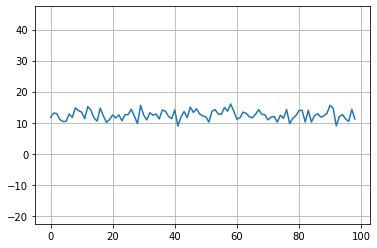

In [40]:
# PROBLEM : POLICY KONVERGIERT FÜR JEDEN STATE ZUR GLEICHEN AKTION -> LÖSUNG: KEINE AHNUNG!
# PROBLEM : falsche umsetzung von Q = NN(s,a). Es muss Q = NN(s) = torch.tensor[A] sein und dann Q[a] selektieren.

world = World(S=2, A=2)
agent = TDAgent()
agent.place(world)
agent.learn(T = 10000, T_fix = 100)